# Assignment 1 - Image Processing

University of Puerto Rico, Río Piedras    
Rémi Mégret, Introduction to Computer Vision    

__Submitted by:__ Daniel Suazo and Eduardo Santin

In [1]:
!git clone --depth=1 https://github.com/scikit-image/skimage-tutorials

fatal: destination path 'skimage-tutorials' already exists and is not an empty directory.


In [2]:
%cd skimage-tutorials/lectures

c:\Users\danie\Documents\Projects\CV Assignment 1\skimage-tutorials\lectures


In [3]:
# First download the example image from
# https://drive.google.com/file/d/1-_OKojT-Xcc0W9dpi83vjSKV4ps4qT-G/view
!gdown --id 1htWnGDGuQhqBNlEY9Ty4eUQvBFwjcNRl -O ../images/img_Hour_00_Minute_00_Second_30_Frame_0000.jpg
!gdown --id 124GBRLUGVPo-_Rq-mpncCpNnZrpimLD6 -O ../images/robocup.jpg

'gdown' is not recognized as an internal or external command,
operable program or batch file.
'gdown' is not recognized as an internal or external command,
operable program or batch file.


In [20]:
# Global imports
%matplotlib inline
import skimage
from skimage import data, io, color, filters, measure, feature, restoration
from skimage.morphology import disk
import matplotlib.pyplot as plt
import matplotlib.colors
from scipy.ndimage.measurements import center_of_mass
from skimage.measure import regionprops
from scipy import ndimage
#import skdemo
import numpy as np
# Add more imports here if needed

## Part A. Basic image manipulation [20]

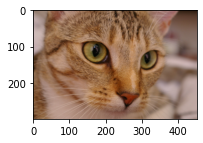

In [21]:
fig = plt.figure(figsize=(4,2))
image = skimage.data.chelsea()
plt.imshow(image)

__Q1.__ What is the size of `image`, and its depth?

In [6]:
y, x, z = image.shape
print(f"width = {x}, height = {y}, depth = {z}")
image.shape

width = 451, height = 300, depth = 3


(300, 451, 3)

Your answer: width = xxx, height = xxx, depth = xxx

__Q2.__ What data type (uint8, float...) is `image`?

In [7]:
type(image)

numpy.ndarray

__Q3.__ Extract and display a 100x100 image centered on one of the eyes of the cat.

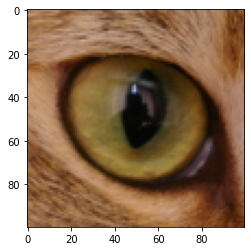

In [8]:
eye = image[65:165, 120:220]
plt.imshow(eye)

__Q4.__ Using slicing operations, mirror `image` by inverting left and right.

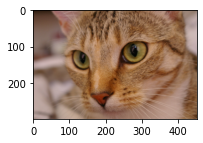

In [9]:
new_image = image[:,::-1,:]
fig = plt.figure(figsize=(4,2))
plt.imshow(new_image)

__Q5.__ Create a new image by adding borders of 100 pixels all around `image`. The border should be a light color (pink, light blue, light green...)

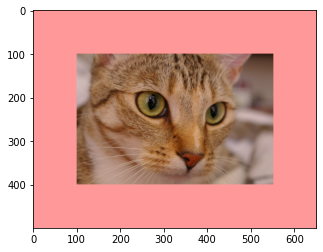

In [23]:
# create new image with border
border_image = np.zeros(shape=(y+200,x+200,z), dtype=np.uint8)
border_image[100:-100,100:-100,:] = image
# top and bottom borders
border_image[0:100, :, :] = (255, 153, 153)
border_image[-100:, :, :] = (255, 153, 153)
# left and right borders
border_image[:, 0:100, :] = (255, 153, 153)
border_image[:, -100:, :] = (255, 153, 153)

plt.imshow(border_image)

## Part B. Color segmentation [40]

In robocup http://www.robocup.org/leagues/7, the ball and the robot players can be detected and tracked using color segmentation.
Using the image below, we want to:
- segment the orange ball (generate a binary mask of the ball)
- segment each robot (generate a binary mask of the robots)

Using the mask, we want to compute the center of each object and display is as a set of crosses overlaid on top of the image. The algorithm should treat the ball and the robot separately so that we know which is which.

Hints: converting to Lab, HSV or Yuv color spaces should help finding good thresholds for segmentation.

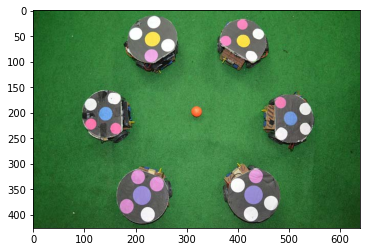

In [11]:
# Image source: http://marvinproject.sourceforge.net/en/examples/robocupSegmentation.html
robocup = io.imread('../images/robocup.jpg')
plt.imshow(robocup)
# plt.imshow(robocup[200:210, 135:140, :])
hsv_robocup = matplotlib.colors.rgb_to_hsv(robocup)


__Computing segmentation mask__

You explanation here: what is your approach? how did you decide which thresholds to use?

To mask the orange ball, a small section of the array was taken in hsv color space to generate initial thresholds, then the thresholds were adjusted until final values were found.

To mask the robots, the same methodology was used to mask out the center colors, being blue, yellow and purple, then the three masks were combined and then the centers of each object were found.

In [12]:
def create_cross(coords, img, color):
    """
    Create a cross at the given coordinates in the image.
    """
    y, x = coords
    x, y = int(x), int(y)
    newimg = img.copy()
    newimg[y-5:y+5, x-1:x+1, :] = color
    newimg[y-1:y+1, x-5:x+5, :] = color
    return newimg

In [13]:
def my_labeling(name, img, size=100):
    labels, count = ndimage.label(img)
    print(f"{count} regions found in {name}")
    

    props = regionprops(labels)
    # obj_areas = [p.area for p in props]
    # obj_areas = [a for a in obj_areas if a > 100]
    # centers = [(p.centroid[0],p.centroid[1]) for p in props]

    obj_areas = []
    centers = []
    for p in props:
        if p.area > size:
            obj_areas.append(p.area)
            centers.append((p.centroid[0],p.centroid[1]))
    
    print(f"{len(centers)} regions found in {name} of size {size} or greater")
    return labels, obj_areas, centers

In [14]:
# mask the ball

# print(hsv_robocup[192:203,312:327,:])
ballmask0 = np.logical_and(hsv_robocup[:,:,0] > 0.03, hsv_robocup[:,:,0] < 0.08)
ballmask1 = hsv_robocup[:,:,1] > 0.6
ballmask2 = hsv_robocup[:,:,2] > 150
ballmask = np.logical_and(np.logical_and(ballmask0, ballmask1),  ballmask2)

bally, ballx = center_of_mass(ballmask)
ballcoords = (int(bally), int(ballx))

In [15]:
# mask the robots
robotmasks = [0] * 6

# Mask yellow dots
yellowmask0 = hsv_robocup[:, :, 0] > 0.1
yellowmask1 = hsv_robocup[:, :, 1] > 0.6
yellowmask2 = hsv_robocup[:, :, 2] > 217
yellowmask = np.logical_and(np.logical_and(
    yellowmask0, yellowmask1),  yellowmask2)

# Mask blue dots
bluemask0 = np.logical_and(hsv_robocup[:, :, 0] > 0.52, hsv_robocup[:, :, 0] < 0.7)
bluemask1 = hsv_robocup[:, :, 1] > 0.4
bluemask2 = hsv_robocup[:, :, 2] > 200
bluemask = np.logical_and(np.logical_and(bluemask0, bluemask1),  bluemask2)
# plt.imshow(bluemask)

# Mask purple dots
purplemask0 = np.logical_and(hsv_robocup[:, :, 0] > 0.65, hsv_robocup[:, :, 0] < .78)
purplemask1 = hsv_robocup[:, :, 1] > 0.10
purplemask2 = hsv_robocup[:, :, 2] > 200
purplemask = np.logical_and(np.logical_and(
    purplemask0, purplemask1),  purplemask2)

# combine masks
robotsmask = np.logical_or(np.logical_or(yellowmask, bluemask), purplemask)


robotlabels, robotareas, robotcenters = my_labeling('robots', robotsmask)

# plt.imshow(robotsmask)

6 regions found in robots
6 regions found in robots of size 100 or greater


__Computing and displaying object centers__

C:\Users\danie\AppData\Local\Temp/ipykernel_27800/2695693727.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "xr" (-> color='r'). The keyword argument will take precedence.
  plt.plot(ballcoords[1], ballcoords[0], 'xr', color="blue")


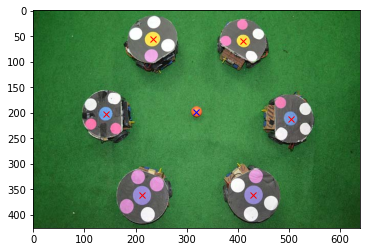

In [42]:
# Your code here (use several cells if needed)
marked_img = np.copy(robocup)
plt.imshow(marked_img)
for i in robotcenters:
    plt.plot(i[1], i[0], 'xr')
    
plt.plot(ballcoords[1], ballcoords[0], 'xr', color="blue")


## Part C. Segmenting noisy images [40]

The following image represents nanoparticles observed using electron microscopy. Due to the scale at which we capture them, there is a lot of noise.

You objective is to segment the particles as best as you can and return the area and position of each particle in a table, as well as show these properties overlayed on the image. A typical pipeline involves:
- denoising (filtering...)
- thresholding
- post-processing (morphology...)
- labeling and object properties
- visualization

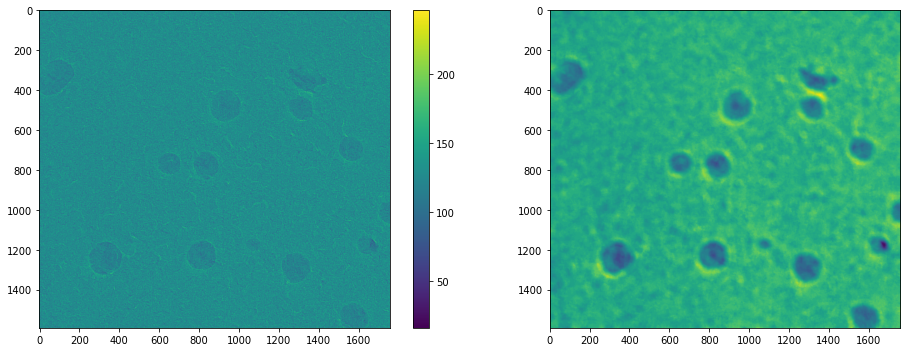

In [24]:
particles0 = io.imread('../images/img_Hour_00_Minute_00_Second_30_Frame_0000.jpg')
particles0_denoised = filters.rank.median(particles0, disk(20))
fig, axes = plt.subplots(1,2,figsize=(14,5))
im0 = axes[0].imshow(particles0)
im1 = axes[1].imshow(particles0_denoised)
fig.colorbar(im0,ax=axes[0])
plt.tight_layout()

This image is not obvious to segment because the histogram does not have separate modes for the particles (slightly darker) and the background (slightly lighter). The noise is just mixing the gray-levels of both.

82 regions found in particles
14 regions found in particles of size 1000 or greater
((341.1564875135722, 94.76364006514657), 14736)
((349.66962496421417, 1322.448468365302), 6986)
((483.04830075936763, 941.8433959915349), 8033)
((488.16134020618557, 1311.5494845360824), 5820)
((693.5275986790376, 1558.6184934738167), 6359)
((769.3511254886104, 839.543469470279), 7419)
((765.5792305184219, 651.750244538637), 6134)
((1008.1795398520953, 1739.5718981101068), 2434)
((1176.5600112170498, 1658.1489063376332), 3566)
((1171.6471172962226, 1074.910536779324), 1006)
((1223.6201112537442, 816.8434745400085), 11685)
((1237.0802938358352, 336.5314595975727), 15655)
((1286.6041501103753, 1282.9537306843267), 11325)
((1536.5145320674287, 1575.4049602790158), 10322)


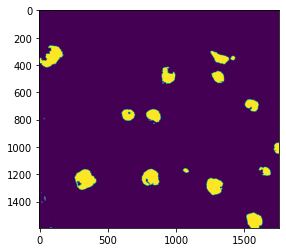

In [39]:
plt.imshow(particles0_denoised < 123)
particlemask = particles0_denoised < 123

particlelabels, particleareas, particlecenters = my_labeling('particles', particlemask, size=1000)
table = [i for i in zip(particlecenters, particleareas)]
for i in table:
    print(i)


Your explanations here: what is your approach to segment the particles?

First the image was denoised using a median filter with a disk size of 20, then the threshold was found to be < 123 and from there, the particles which had an area greater than 1000, which was found to be a good point where all particles were detected and there were no false positives, were detected, stored and displayed.

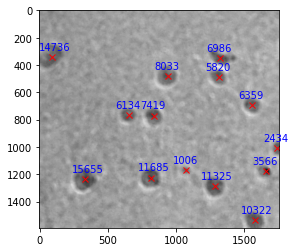

In [40]:
plt.imshow(particles0_denoised, cmap='gray')

for coords, area in table:
    plt.plot(coords[1], coords[0], 'xr')
    plt.text(coords[1] - 100, coords[0] - 50, area, color='blue')